In [ ]:
# WeatherPy, by Robert Orr
# Key Takeaways
# 1. Temperature increases as one moves north the equator, 
#    but most cities are in the north so this relationship could symetric (I know it actually is).
# 2. Windspeed seems to increase as latitude increase, and, once again the bias from cities disproportionately 
#    being situated in the norther hemisphere.
# 3. There does not seem to be any discernable relationship in regarding latitude and cloudiness
# 4. Humidity appears to a non-linear relationship with latitude. It is low at the equator, but grows as you move in
#    either direction, and then declines once again when moving towards the poles.

In [52]:
# Dependencies
import json
import requests
from citipy import citipy
import csv
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
import os
from scipy.stats import linregress
#Key
from config import weather_key

In [38]:
#Assign random lat/lng points from possible universe of possibilities
x, y = uniform(-180,180), uniform(-90, 90)
def newpoint():
    return uniform(-180,180), uniform(-90, 90)
coordinates = []
points = (newpoint() for x in range(40000))
for point in points:
    coordinates.append(point)
cities_df = pd.DataFrame(coordinates)
cities_df.columns = ['lat', 'lon']
cities_df['city'] = ''
cities_df['country_code'] = ''
cities_df['city_lat'] = ''
cities_df['city_lon'] = ''
cities_df['city_temperature'] = ''
cities_df['city_humidity'] = ''
cities_df['city_windspeed'] = ''
cities_df['city_clouds'] = ''
cities_df['city_temp_max'] = ''
cities_df['date'] = ''
cities_df['sunrise'] = ''

In [39]:
# Match with cities
for (idx,row) in cities_df.iterrows():
    city = citipy.nearest_city(row["lat"],row["lon"])
    country_code = city.country_code
    name = city.city_name
    cities_df.at[idx, 'city'] = name
    cities_df.at[idx, 'country_code'] = country_code
cities_df = cities_df.drop_duplicates('city')
url = "http://api.openweathermap.org/data/2.5/weather?"
cities_df['city'] = cities_df['city'].str.title()
cities_df['country_code'] = cities_df['country_code'].str.upper()
cities_df.head()

,lat,lon,city,country_code,city_lat,city_lon,city_temperature,city_humidity,city_windspeed,city_clouds,city_temp_max,date,sunrise
0,-95.940721,0.439120,Hermanus,ZA,,,,,,,,,
1,-8.676211,22.801352,Mwene-Ditu,CD,,,,,,,,,
2,69.471457,-64.495955,Pangnirtung,CA,,,,,,,,,
3,-147.838324,12.510842,Bredasdorp,ZA,,,,,,,,,
4,-6.607505,-16.562434,Georgetown,SH,,,,,,,,,


In [50]:
# Run Loops Querrying the API
# Loop: Establish Exact City Coordinates and the Time of Sunrise
counter = 0
for (idx,row) in cities_df.iterrows():
    try:
        counter += 1
        city = (row.loc['city'])
        country_code = (row.loc['country_code'])
        query_url = (url +'units=imperial'+"&appid=" + weather_key + "&q=" +city+", "+country_code)
        weather_response = requests.get(query_url)
        weather_json = weather_response.json()
        latitude_city= weather_json["coord"]["lat"]
        longitude_city= weather_json["coord"]["lon"]
        sunrise= weather_json["sys"]["sunrise"]
        cities_df.at[idx, 'sunrise']= sunrise= weather_json["sys"]["sunrise"]
        cities_df.at[idx, 'city_lat'] = latitude_city
        cities_df.at[idx, 'city_lon'] = longitude_city
        print(f"Processing Record {counter} Set 1 | {city} \n {query_url}")
    except KeyError:
        pass

#Drop NA values to speed up the second loop
cities_df = cities_df.drop_duplicates(subset=['city', 'country_code'])
cities_df['city_lat'].replace('', np.nan, inplace=True)
cities_df=cities_df.dropna()

#Loop 2: Collect weather data based on specific gathered from Loop 1
counter = 0
for (idx,row) in cities_df.iterrows():
    try:
        counter += 1
        city = (row.loc['city'])
        country_code = (row.loc['country_code'])
        start = (row.loc['sunrise'])
        end = (row.loc['sunrise'])
        end= str(end)
        start= str(start)
        query_url = (url +'units=imperial'+"&start="+start+"&end="+end+ "&appid=" + weather_key + "&q=" +city+", "+country_code)
        weather_response = requests.get(query_url)
        weather_json = weather_response.json()
        temperature = weather_json["main"]["temp"]
        clouds = weather_json["clouds"]['all']
        windspeed = weather_json["wind"]['speed']
        humidity = weather_json["main"]["humidity"]
        date= weather_json["dt"]
        temp_max = weather_json["main"]["temp_max"]
        cities_df.at[idx, 'city_temperature'] = temperature
        cities_df.at[idx, 'city_humidity'] = humidity
        cities_df.at[idx, 'city_clouds'] = clouds
        cities_df.at[idx, 'city_windspeed'] = windspeed
        cities_df.at[idx, 'city_temp_max'] = temp_max
        cities_df.at[idx, 'date'] = date
        print(f"Processing Record {counter} Set 2 | {city} \n {query_url}")
    except KeyError:
        pass

Processing Record 1 Set 1 | Hermanus 
 http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=2fff46cae0837549e79ccf0582b9fce3&q=Hermanus, ZA
Processing Record 2 Set 1 | Mwene-Ditu 
 http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=2fff46cae0837549e79ccf0582b9fce3&q=Mwene-Ditu, CD
Processing Record 3 Set 1 | Pangnirtung 
 http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=2fff46cae0837549e79ccf0582b9fce3&q=Pangnirtung, CA
Processing Record 4 Set 1 | Bredasdorp 
 http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=2fff46cae0837549e79ccf0582b9fce3&q=Bredasdorp, ZA
Processing Record 5 Set 1 | Georgetown 
 http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=2fff46cae0837549e79ccf0582b9fce3&q=Georgetown, SH
Processing Record 6 Set 1 | Qaanaaq 
 http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=2fff46cae0837549e79ccf0582b9fce3&q=Qaanaaq, GL
Processing Record 7 Set 1 | Ushuaia 
 http://api.openw

ProxyError: HTTPConnectionPool(host='127.0.0.1', port=7769): Max retries exceeded with url: http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=2fff46cae0837549e79ccf0582b9fce3&q=Sao%20Jose%20Da%20Coroa%20Grande,%20BR (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response',)))

In [59]:
# Count numb of Entries (Should be less than inital) and prepare numeric values for analyses 
cities_df['city_lon'].replace('', np.nan, inplace=True)
cities_df['city_humidity'].replace('', np.nan, inplace=True)
cities_df['city_temperature'].replace('', np.nan, inplace=True)
cities_df['city_windspeed'].replace('', np.nan, inplace=True)
cities_df['city_clouds'].replace('', np.nan, inplace=True)
cities_df['city_temp_max'].replace('', np.nan, inplace=True)
cities_df=cities_df.dropna()

print(cities_df.count())

lat                 3244
lon                 3244
city                3244
country_code        3244
city_lat            3244
city_lon            3244
city_temperature    3244
city_humidity       3244
city_windspeed      3244
city_clouds         3244
city_temp_max       3244
date                3244
sunrise             3244
dtype: int64


In [78]:
# Save data to return to analyses without running the API loops again.
cities_df.to_csv('../Resources/city_weather_stats.csv')
city_stats=cities_df.copy()

#Uncheck below line to read back in previously saved data.
#city_stats = pd.read_csv('/Users/rorr/PythonStuff/Resources/city_weather_stats.csv')

#View Head
city_stats.head()

,lat,lon,city,country_code,city_lat,city_lon,city_temperature,city_humidity,city_windspeed,city_clouds,city_temp_max,date,sunrise
0,-95.940721,0.439120,Hermanus,ZA,-34.42,19.24,67.34,69,5.28,8,67.34,1522777172,1522731446
1,-8.676211,22.801352,Mwene-Ditu,CD,-7.01,23.45,68.24,93,3.94,92,68.24,1522777181,1522729722
2,69.471457,-64.495955,Pangnirtung,CA,66.15,-65.72,30.20,63,8.05,75,30.20,1522774800,1522747545
3,-147.838324,12.510842,Bredasdorp,ZA,-34.53,20.04,69.80,77,9.17,44,69.80,1522774800,1522731258
4,-6.607505,-16.562434,Georgetown,SH,-7.93,-14.42,79.94,100,11.77,8,79.94,1522777055,1522738832


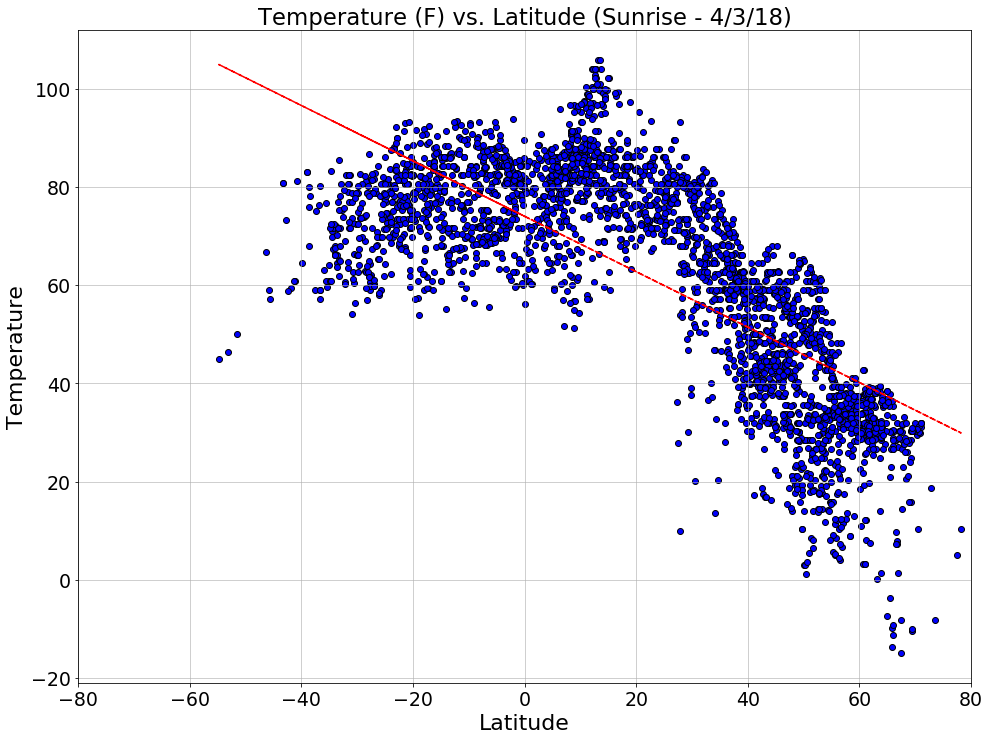

In [79]:
#1. Temperature (F) vs. Latitude
(slope, intercept, _, _, _) = linregress(city_stats['city_lat'], city_stats['city_temperature'])
fit = slope * city_stats['city_lat'] + intercept
plt.rc('figure', figsize=(16, 12))
plt.rcParams.update({'font.size': 19})
plt.scatter(city_stats['city_lat'], city_stats['city_temperature'], marker="o", edgecolors="black"
, color='blue')
plt.title("Temperature (F) vs. Latitude (Sunrise - 4/3/18)")
plt.grid(alpha=.75)
plt.xlim(-80, 80)
plt.xlabel("Latitude", fontsize=22)
plt.ylabel("Temperature", fontsize=22)
plt.plot(city_stats['city_lat'], fit, 'r--')
plt.savefig('Temperature.png')
plt.show()

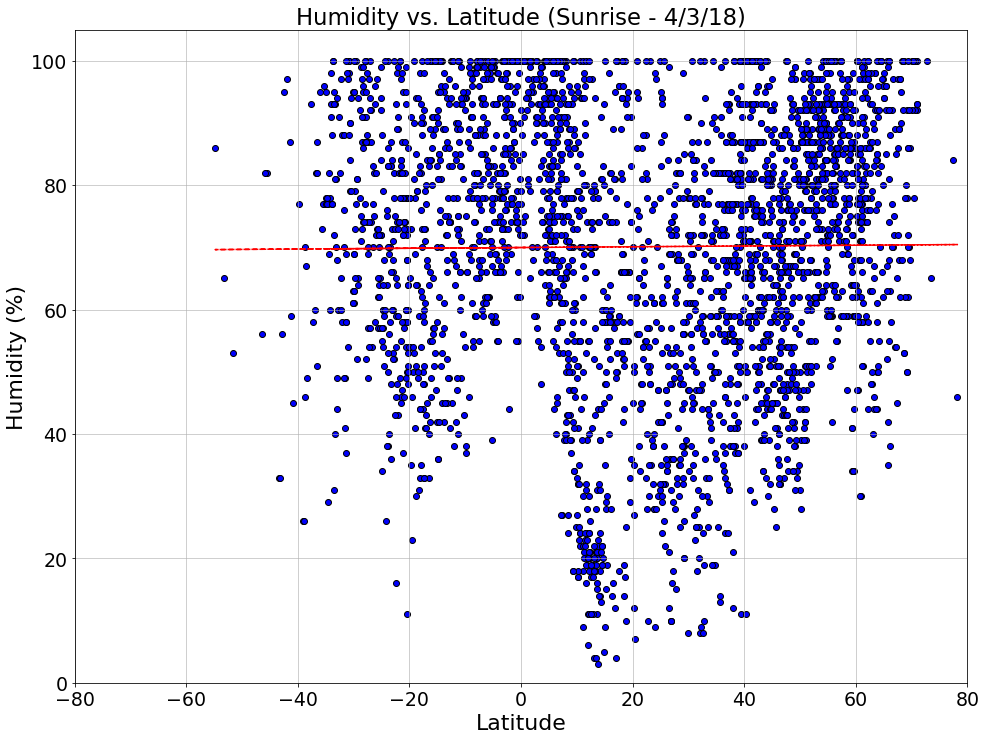

In [80]:
#2. Humidity (%) vs. Latitude
plt.rc('figure', figsize=(16, 12))
plt.rcParams.update({'font.size': 19})
plt.scatter(city_stats['city_lat'], city_stats['city_humidity'], marker="o", edgecolors="black"
, color='blue')
plt.title("Humidity vs. Latitude (Sunrise - 4/3/18)")
plt.grid(alpha=.75)
plt.xlabel("Latitude", fontsize=22)
plt.ylabel("Humidity (%)", fontsize=22)
plt.xlim(-80, 80)
plt.ylim(0,)
(slope, intercept, _, _, _) = linregress(city_stats['city_lat'], city_stats['city_humidity'])
fit = slope * city_stats['city_lat'] + intercept
plt.plot(city_stats['city_lat'], fit, 'r--')
plt.savefig('Humidity.png')
plt.show()

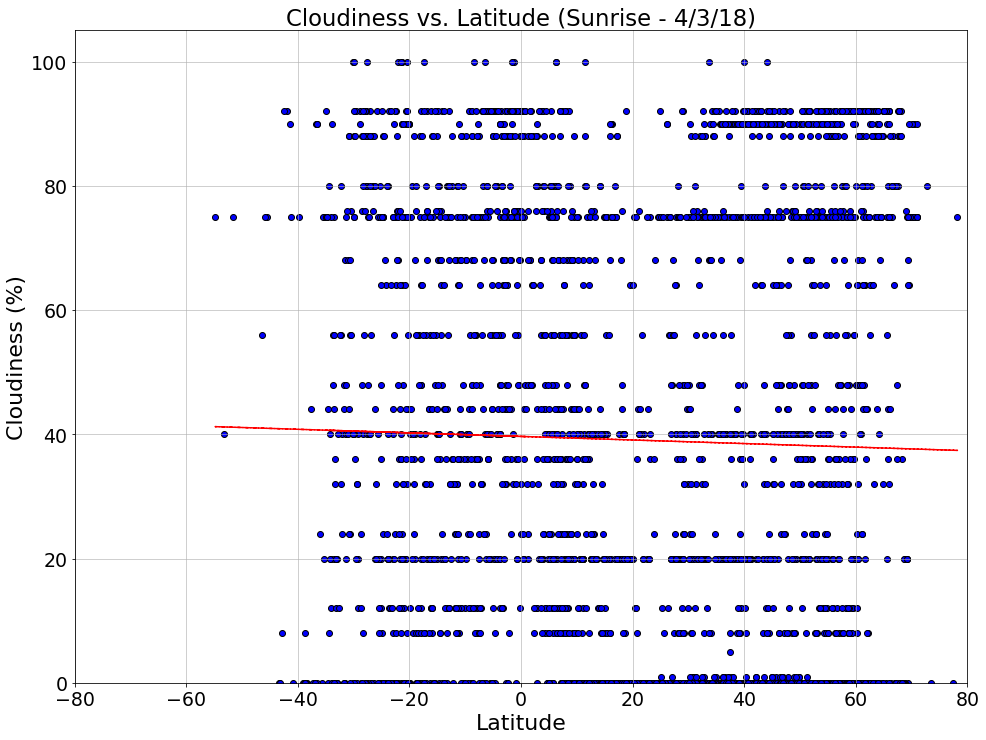

In [81]:
#3. Cloudiness (%) vs. Latitude
plt.rc('figure', figsize=(16, 12))
plt.rcParams.update({'font.size': 19})
plt.scatter(city_stats['city_lat'], city_stats['city_clouds'], marker="o", edgecolors="black", color='blue')
plt.title("Cloudiness vs. Latitude (Sunrise - 4/3/18)")
plt.grid(alpha=.75)
plt.xlabel("Latitude", fontsize=22)
plt.ylabel("Cloudiness (%)", fontsize=22)
plt.xlim(-80, 80)
plt.ylim(0,)
(slope, intercept, _, _, _) = linregress(city_stats['city_lat'], city_stats['city_clouds'])
fit = slope * city_stats['city_lat'] + intercept
plt.plot(city_stats['city_lat'], fit, 'r--')
plt.savefig('Clouds.png')
plt.show()

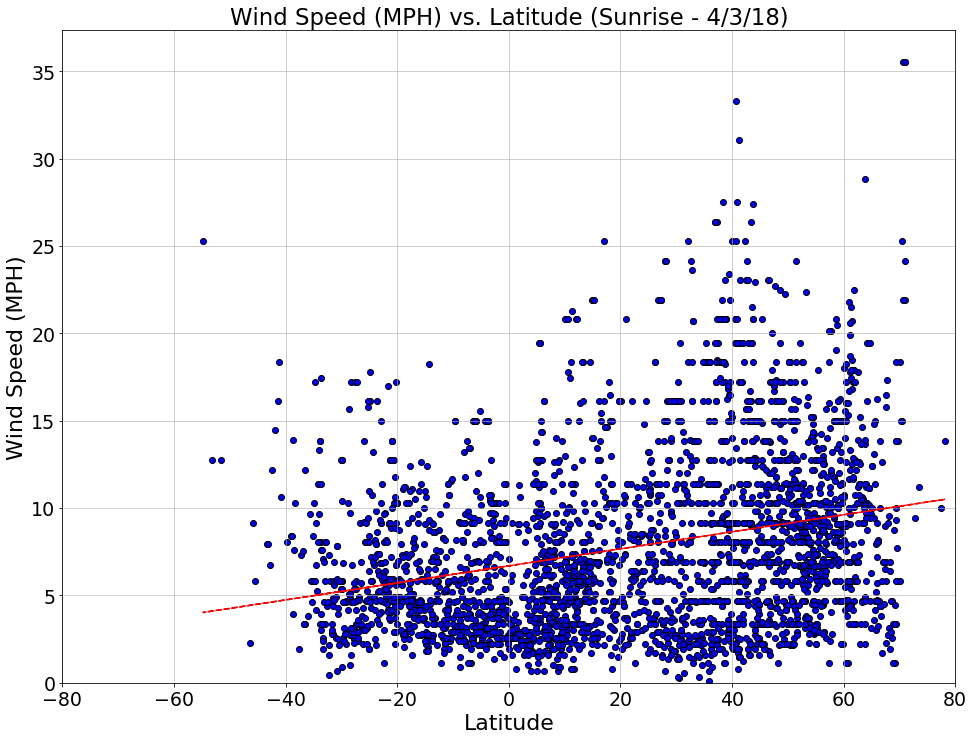

In [82]:
#4. Wind Speed (mph) vs. Latitude
plt.rc('figure', figsize=(16, 12))
plt.rcParams.update({'font.size': 19})
plt.scatter(city_stats['city_lat'], city_stats['city_windspeed'], marker="o", edgecolors="black"
, color='blue')
plt.title("Wind Speed (MPH) vs. Latitude (Sunrise - 4/3/18)")
plt.grid(alpha=.75)
plt.xlabel("Latitude", fontsize=22)
plt.ylabel("Wind Speed (MPH)", fontsize=22)
plt.xlim(-80, 80)
plt.ylim(0,)
(slope, intercept, _, _, _) = linregress(city_stats['city_lat'], city_stats['city_windspeed'])
fit = slope * city_stats['city_lat'] + intercept
plt.plot(city_stats['city_lat'], fit, 'r--')
plt.savefig('Wind-Speed.png')
plt.show()
